# Moscow House Pricing EDA

## Loading data

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Reading CSV-files
apartments_train = pd.read_csv("data/apartments_train.csv")
buildings_train = pd.read_csv("data/buildings_train.csv")
apartments_test = pd.read_csv("data/apartments_test.csv")
buildings_test = pd.read_csv("data/buildings_test.csv")

# Merge Tables: Apartments and Buildings
train_df = apartments_train.merge(buildings_train, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')
test_df = apartments_test.merge(buildings_test, left_on='building_id', right_on='id', suffixes=('', '_r')).sort_values('id').set_index('id')

# Add new features
center = np.array([37.6, 55.76]) # longitude, latitude
train_df['center_distance'] = np.linalg.norm(train_df[['longitude', 'latitude']] - center, axis=1)
test_df['center_distance'] = np.linalg.norm(test_df[['longitude', 'latitude']] - center, axis=1)

# Average price per district
mean_price = train_df.groupby('district').mean().reset_index()[['district', 'price']]
train_df = train_df.merge(mean_price, how='left', on='district', suffixes=('', '_avg'))
test_df = test_df.merge(mean_price, how='left', on='district').rename(columns={'price' : 'price_avg'}).set_index(test_df.index)

# Distance to nearest metro station
metro_locs = pd.read_csv("data/metro_stations.csv")[['longitude','latitude']].to_numpy()
house_locs_train = train_df[['longitude','latitude']].to_numpy()
house_locs_test = test_df[['longitude','latitude']].to_numpy()
dists_train = np.min(np.linalg.norm(house_locs_train[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
dists_test = np.min(np.linalg.norm(house_locs_test[:, np.newaxis, :] - metro_locs, axis=2), axis=1)
train_df['closest_metro'] = dists_train
test_df['closest_metro'] = dists_test

# Splitting data into train and validation set
X_train, X_val, y_train, y_val = train_test_split(train_df, train_df.price, train_size=0.999, random_state=0)
X_train = X_train.drop(['building_id', 'street', 'price', 'id_r', 'address', 'area_living', 'area_kitchen', 'rooms'], axis=1)
print(train_df["building_id"].shape)
print(train_df["building_id"].unique().shape)
X_val = X_val.drop(['building_id', 'street', 'price', 'id_r', 'address', 'area_living', 'area_kitchen', 'rooms'], axis=1)
X_test = test_df.drop(['building_id', 'id_r', 'street', 'address'], axis=1)

train_df.describe()


(6791,)


,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,...,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,center_distance,price_avg,closest_metro
count,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,...,23285.000000,22928.000000,22928.000000,22928.000000,16497.000000,14474.000000,15124.000000,23285.000000,2.315500e+04,23285.000000
mean,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,...,17.608933,0.392620,0.929867,0.743109,0.572589,0.806411,0.176012,0.154858,2.365041e+07,0.020317
std,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,...,11.216638,0.488344,0.255376,0.436928,0.549630,0.395124,0.566275,0.101090,2.237497e+07,0.044926
min,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001904,5.706130e+06,0.000116
25%,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,...,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.089378,1.057349e+07,0.006994
50%,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,...,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.136458,1.658807e+07,0.010860
75%,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,...,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.202623,1.974773e+07,0.017198
max,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,...,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,0.806078,8.392784e+07,0.512452


## Analyze Target Distribution

In order to avoid negative price pedictions by the regressorsb
Log-transform target variable:

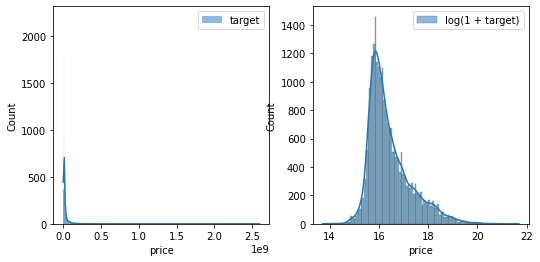

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(left=-0.2)

trans_data = pd.DataFrame(np.log1p(train_df["price"]), columns=["price"])

sns.histplot(train_df, x="price", label="target", kde=True, ax=ax1)
sns.histplot(trans_data, x="price", label="log(1 + target)", kde=True, ax=ax2)

ax1.legend()
ax2.legend();

## Plot Covariance

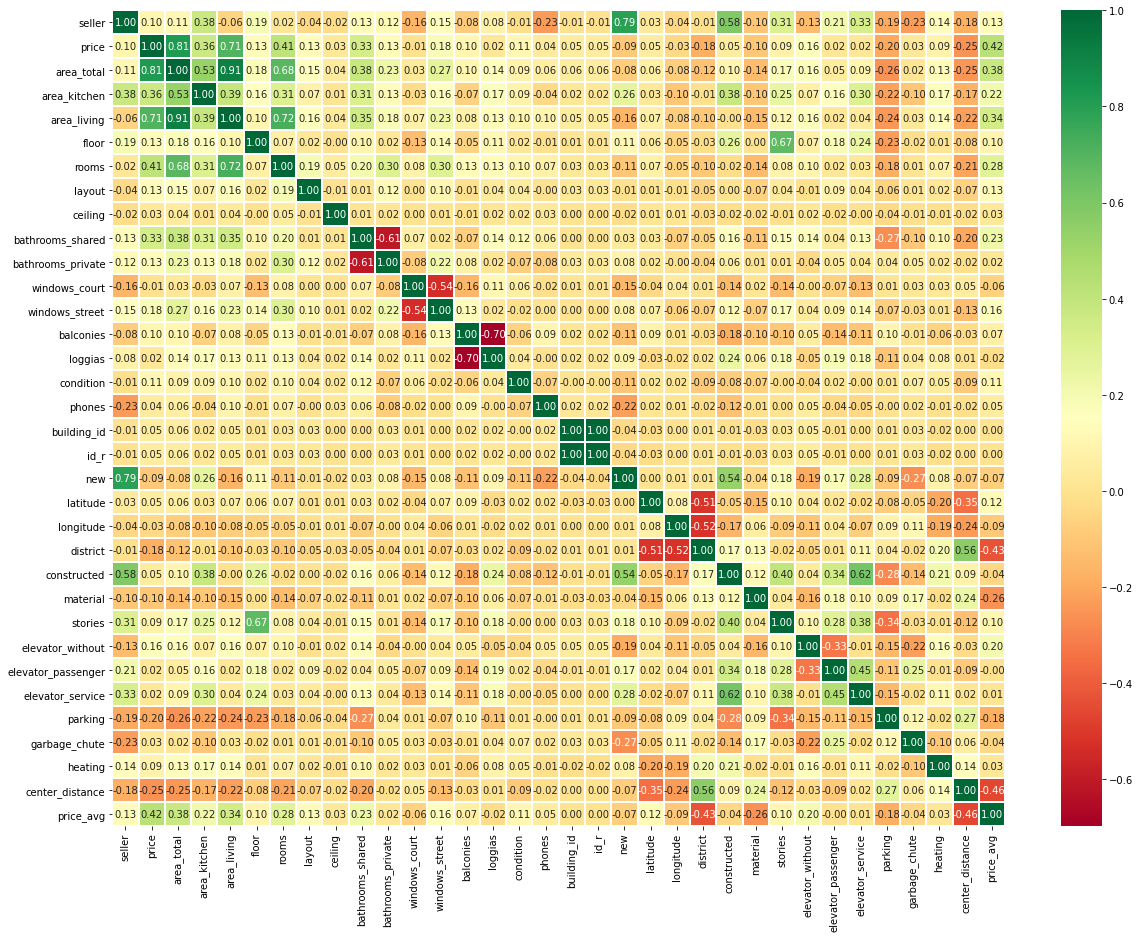

In [44]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), xticklabels=True, yticklabels=True, cmap='RdYlGn', linewidths=.2, annot=True, fmt=".2f");

## Analyze Feature Importance

In [1]:
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
from sklearn.compose import TransformedTargetRegressor

model_xgb = XGBRegressor(n_estimators=1200, max_depth=7, booster='gbtree')
model_xgb.fit(X_train, y_train)

plt.figure(figsize=(20, 15))
plot_importance(model_xgb, max_num_features=25);

NameError: name 'X_train' is not defined

##

## 3. Analyze Missing Values and Find Best Imputation

Plot how missing values are scattered along the dataset (White segments represent missing values):

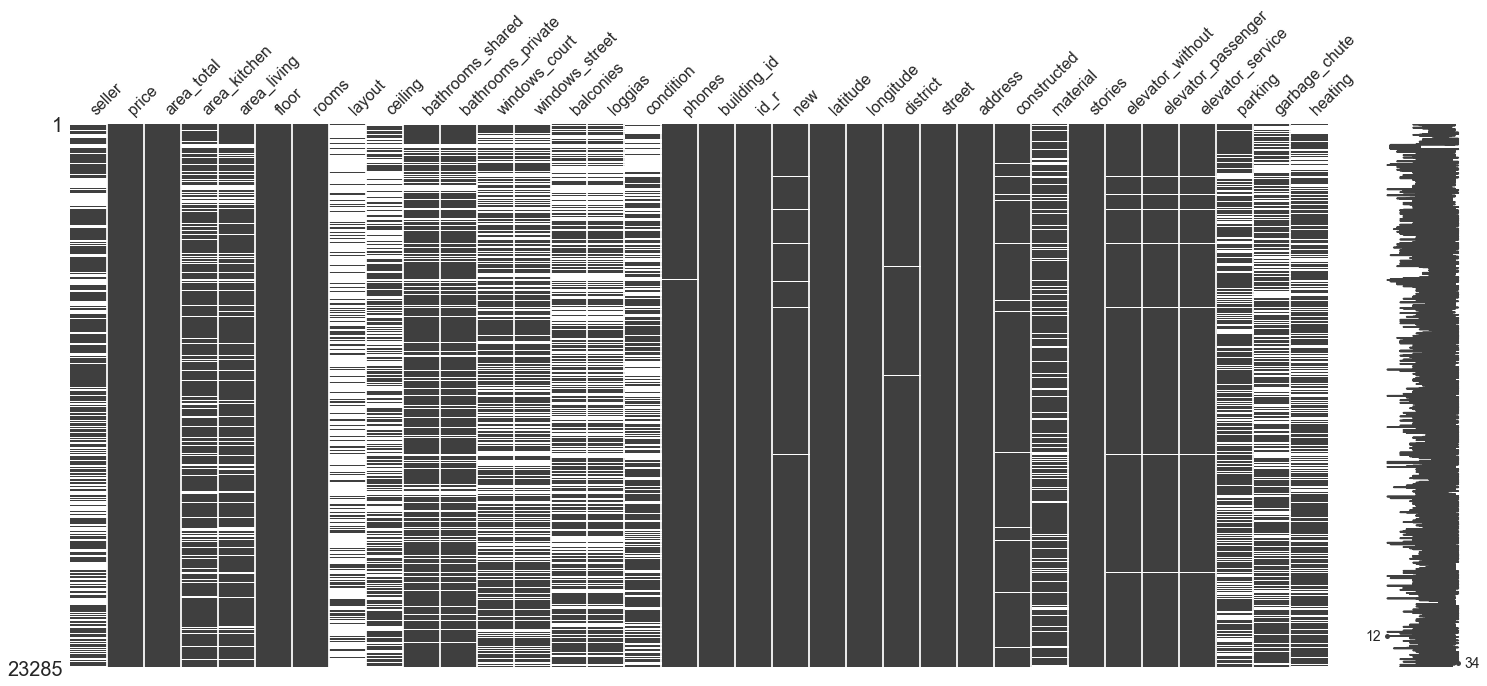

In [ ]:
import missingno as msno
msno.matrix(train_df);

Plotting correlations between missing values to find out correlation between missing values:

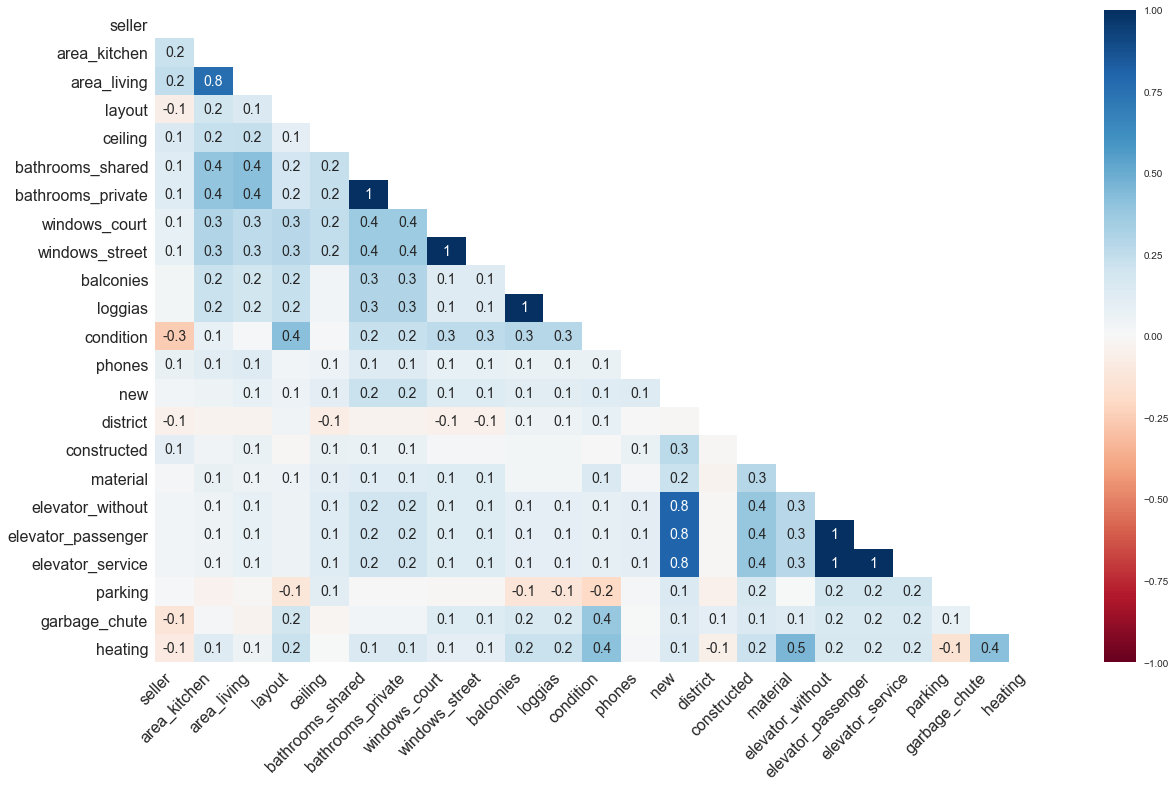

In [ ]:
msno.heatmap(train_df);

Comparing the following imputers on the whole data set:
- SimpleImputer (numerical features -> mean, catagorical features -> most_frequent)
- KNN-Imputer (k=2, k=3, k=5, k=7, k=9)
- IterativeImputer (BayesianRidge, ExtraTreeRegressor)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

from catboost import CatBoostRegressor

In [49]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

model_cat = CatBoostRegressor(iterations=2000, depth=7, learning_rate=0.15, l2_leaf_reg=0.45, silent=True)
trans_cat = TransformedTargetRegressor(regressor=model_cat, func=np.log1p, inverse_func=np.expm1)

np.random.seed(42069)

# Simple Imputer
categorical_columns = ["seller", "layout", "condition", "district", "material", "parking", "heating"]
numerical_columns = X_train.drop(categorical_columns, axis=1).columns

imputer = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), numerical_columns),
        ('cat', SimpleImputer(strategy="most_frequent"), categorical_columns)
])

pipe = make_pipeline(imputer, trans_cat)
print("Running SimpleImputer")
si_scores = pd.DataFrame(cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle)), columns="Simple Imputer")


# Iterative Imputer
ii_scores = pd.DataFrame()
for estimator in [BayesianRidge()]:
    print("Running IterativeImputer", estimator.__class__.__name__)
    pipe = make_pipeline(IterativeImputer(estimator=estimator), trans_cat)
    ii_scores[estimator.__class__.__name__] = cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle))


# KNN Imputer
knn_scores = pd.DataFrame()
n_neighbors = [2, 3, 5, 7, 9]
for k in n_neighbors:
    print("Running KNNImputer", k)
    pipe = make_pipeline(KNNImputer(n_neighbors=k), trans_cat)
    knn_scores[f"KNN(k = {k})"] = cross_val_score(pipe, X_train, y_train, scoring=make_scorer(rmsle))


# Combine scores into single dataframe
final_scores = pd.concat([ii_scores, knn_scores, si_scores], axis=1, keys=["iterative_imputer", "knn_imputer", "simple_imputer"])

Running SimpleImputer


TypeError: Index(...) must be called with a collection of some kind, 'Simple Imputer' was passed

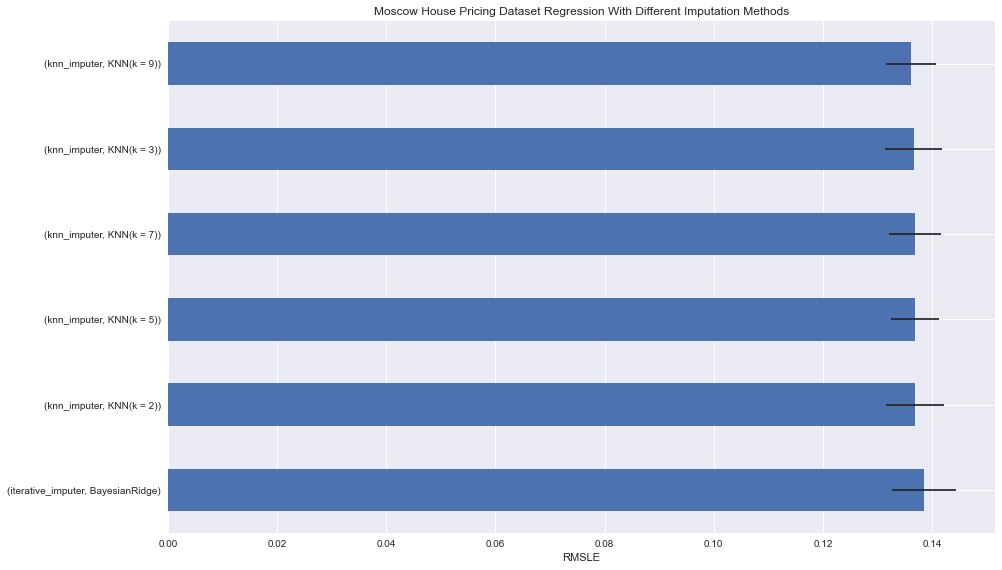

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

means, errors = final_scores.mean().sort_values(ascending=False), final_scores.std()
means.plot.barh(xerr=errors, ax=ax)

ax.set_title("Moscow House Pricing Dataset Regression With Different Imputation Methods")
ax.set_xlabel("RMSLE")
ax.set_yticks(np.arange(means.shape[0]))
plt.tight_layout(pad=1)